#### Hidden Manifolds in High Dimensional Space


Run dimensionality reduction on spike counts.


In [1]:
from __future__ import division
import numpy as np
import numpy.linalg as la
import sys, time, os, datetime
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition, manifold

In [2]:
import matplotlib.pyplot as plt

In [3]:
sd=int((time.time()%1)*(2**31))
np.random.seed(sd)
curr_date=datetime.datetime.now().strftime('%Y_%m_%d')+'_'

gen_fn_dir = os.path.abspath('..') + '/shared_scripts'
sys.path.append(gen_fn_dir)

import general_file_fns as gff

gen_params = gff.load_pickle_file('../general_params/general_params.p')

from binned_spikes_class import spike_counts
from dim_red_fns import run_dim_red

In [4]:
cols = gen_params['cols']
dir_to_save = gff.return_dir(gen_params['results_dir'] + '2019_06_03_dim_red/')

command_line = False
if command_line:
    session = sys.argv[1]
    state = sys.argv[2]
    # If condition is 'joint' should unpack state into first and second
    condition = sys.argv[3]
    target_dim = int(sys.argv[4])
    desired_nSamples = int(sys.argv[5])
else:
    session = 'Mouse28-140313'
    state = 'Wake'; #state2 = 'REM'
    condition = 'solo'
    target_dim = 3
    desired_nSamples = 15000

print('Session %s, condition %s, target_dim %d, desired_nSamples %d'%(session, condition,
    target_dim, desired_nSamples))
area = 'ADn'
dt_kernel = 0.1
sigma = 0.1 # Kernel width
rate_params = {'dt' : dt_kernel, 'sigma' : sigma}
method = 'iso'
n_neighbors = 5
dim_red_params = {'n_neighbors' : n_neighbors, 'target_dim' : target_dim}
to_plot = True

session_rates = spike_counts(session, rate_params, count_type='rate', 
    anat_region='ADn')

Session Mouse28-140313, condition solo, target_dim 3, desired_nSamples 15000


In [5]:
counts, tmp_angles = session_rates.get_spike_matrix(state)

In [6]:
#22 cells
len(session_rates.cell_ids)

22

In [7]:
counts.shape

(22864, 22)

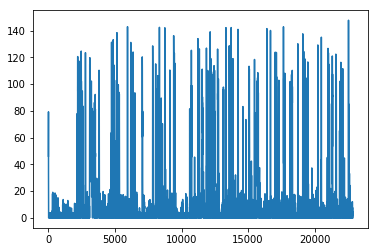

In [8]:
plt.plot(counts[:,3])
plt.show()

In [9]:
t0 = time.time()
if condition == 'solo':
    counts, tmp_angles = session_rates.get_spike_matrix(state)
    
    ##Yonar's edit
    #idx = np.random.rand(*counts.shape).argsort(0)
    #counts_shuffled = counts[idx, np.arange(counts.shape[1])]
    #sel_counts = counts_shuffled[:desired_nSamples]
    #np.random.shuffle(counts)
    
    sel_counts = counts[:desired_nSamples,:6]
    
    proj = run_dim_red(sel_counts, params=dim_red_params, method=method)
    to_save = {'seed' : sd, state : proj, 'meas_angles' : tmp_angles[:desired_nSamples]}
    fname = '%s_%s_kern_%dms_sigma_%dms_binsep_%s_embed_%s_%ddims_%dneighbors_%d.p'%(
        session, area, sigma * 1000, dt_kernel * 1000, state, method, target_dim, n_neighbors, 
       sd)
elif condition == 'joint':
    counts1, _ = session_rates.get_spike_matrix(state)
    counts2, _ = session_rates.get_spike_matrix(state2)
    print('Counts for each ', len(counts1), len(counts2))
    nSamples = min(len(counts1), len(counts2), desired_nSamples)
    print('nSamples = ', nSamples)
    sel1 = counts1[:nSamples]; sel2 = counts2[:nSamples]
    concat_counts = np.concatenate((sel1,sel2),0)
    proj = run_dim_red(concat_counts, params=dim_red_params, method=method)
    to_save = {'seed':sd, state : proj[:nSamples].copy(), 
        state2 : proj[nSamples:].copy()}
    fname = '%s_%s_kern_%dms_sigma_%dms_binsep_%s_%s_embed_%s_%ddims_%dneighbors_%d.p'%(
        session, area, sigma * 1000, dt_kernel * 1000, state, state2, method, target_dim,
        n_neighbors, sd)
gff.save_pickle_file(to_save, dir_to_save + fname)
print('Time ', time.time() - t0)

('Time ', 124.4318699836731)


In [10]:
to_save

{'Wake': array([[ 5.971016  , -7.83189742, -0.79361333],
        [ 6.82983939, -8.85612214, -1.01156618],
        [ 6.67112947, -8.76303298, -1.32900218],
        ...,
        [-1.06075102,  0.45298113, -0.97470343],
        [-1.07499787, -0.5668679 , -0.67025568],
        [-1.38537369, -1.67911078, -0.50881111]]),
 'meas_angles': array([    nan, 3.6597 , 3.70405, ..., 1.69625, 1.6816 , 1.6586 ]),
 'seed': 216745472}

In [11]:
print sel_counts.shape
print proj.shape
print tmp_angles.shape

(15000, 6)
(15000, 3)
(22864,)


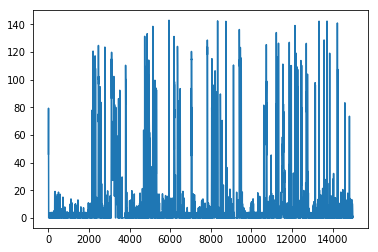

In [12]:
plt.plot(sel_counts[:,3])
plt.show()

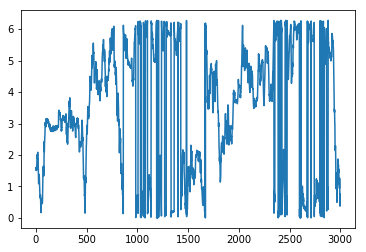

In [13]:
plt.plot(tmp_angles[3000:6000])
plt.show()

In [170]:
%matplotlib notebook

In [14]:
%matplotlib inline

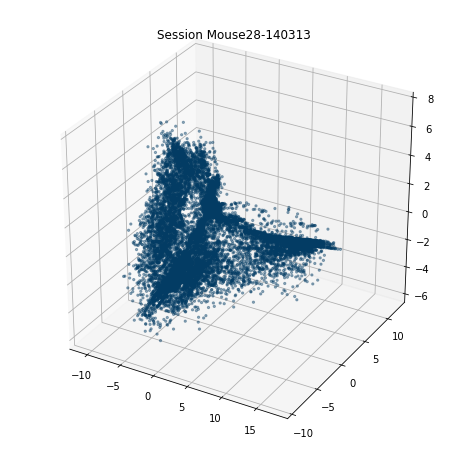

In [22]:
# plotting
if to_plot:
    fig = plt.figure(figsize=(8,8))
    if target_dim == 1:
        ax = fig.add_subplot(111)
        ax.scatter(range(0,desired_nSamples), to_save[state], s=10, alpha=0.4, 
            color=cols[state])
        if condition == 'joint':
            ax.scatter(to_save[state2][:,0], to_save[state2][:,1], s=10, alpha=0.4, 
                color=cols[state2])
    if target_dim == 2:
        ax = fig.add_subplot(111)
        ax.scatter(to_save[state][:,0], to_save[state][:,1], s=10, alpha=0.4, 
            color=cols[state])
        if condition == 'joint':
            ax.scatter(to_save[state2][:,0], to_save[state2][:,1], s=10, alpha=0.4, 
                color=cols[state2])
    if target_dim == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(to_save[state][:,0], to_save[state][:,1], to_save[state][:,2], 
            s=5, alpha=0.4, edgecolor='face', c=cols[state])
        if condition == 'joint':
            ax.scatter(to_save[state2][:,0], to_save[state2][:,1], to_save[state2][:,2], 
                s=5, alpha=0.4, edgecolor='face', c=cols[state2])
    ax.set_title('Session %s'%(session))
    plt.show()

The data from a single session in which 22 neurons recorded from thalamus above is reduced using a nonlinear dim-red method to visualize in 3-d space.

In [ ]:
plt.scatter(tmp_angles[0:15000], to_save[state], s=10, alpha=0.4, 
            color=cols[state])
plt.show()

In [23]:
counts.shape

(22864, 22)

## Finding the right manifold in high dimensional space

I will visualize the manifold above for a random window of time. Then, I will add random nosiy neurons to the recording set to increase the dimensionality of the data. More importantly to introduce irrelevant dimensions to the dataset. Then, I will use the nonlinear mapping again to see how these irrelevant dimensions changes the mapping and ability to discover a manifold on low dimensional space.

In [24]:
# Non-linear Dimensionality Reduction 
target_dim = 3
iso = manifold.Isomap(n_neighbors=5, n_components=target_dim)
#iso = manifold.MDS(n_components=3)
counts_dimred = iso.fit_transform(counts[3000:6000]) #2000:5000

In [25]:
counts_dimred.shape[0]

3000

In [26]:
def plot_manifold(counts_dimred):
    # plot 3-d scatter
    clr = range(0,counts_dimred.shape[0])
    if to_plot:
        fig = plt.figure(figsize=(8,8))
        if target_dim == 1:
            ax = fig.add_subplot(111)
            ax.scatter(range(0,counts_dimred.shape[0]), counts_dimred, s=10, alpha=0.4, 
                color=clr)
            if condition == 'joint':
                ax.scatter(counts_dimred[:,0], counts_dimred[:,1], s=10, alpha=0.4, 
                    color=cols[state2])
        if target_dim == 2:
            ax = fig.add_subplot(111)
            ax.scatter(counts_dimred[:,0], counts_dimred[:,1], s=10, alpha=0.4, 
                color=clr)
            if condition == 'joint':
                ax.scatter(counts_dimred[:,0], counts_dimred[:,1], s=10, alpha=0.4, 
                    color=cols[state2])
        if target_dim == 3:
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(counts_dimred[:,0], counts_dimred[:,1], counts_dimred[:,2], 
                s=5, alpha=0.4, edgecolor='face', c=cols[state])
            if condition == 'joint':
                ax.scatter(counts_dimred[:,0], counts_dimred[:,1], counts_dimred[:,2], 
                    s=5, alpha=0.4, edgecolor='face', c=cols[state2])
        ax.set_title('Session %s'%(session))
        plt.show()  

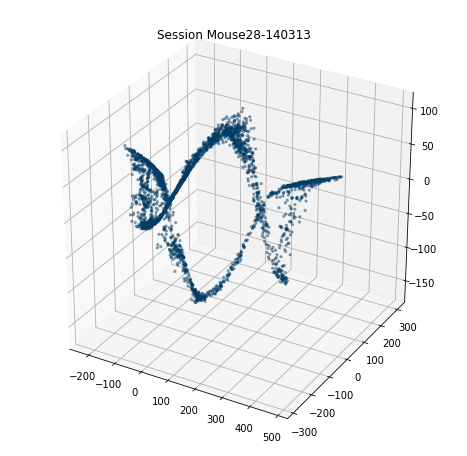

In [27]:
plot_manifold(counts_dimred)

In [28]:
# Add more neurons by generating new neuron through shuffling original neurons. 
# This will allow me to keep similar statistics for each additional neuron but will get rid of any correlations.
import copy
counts2 = copy.deepcopy(counts)

In [29]:
counts2[0]

array([8.71182268e+000, 2.02239637e-020, 6.41130264e-095, 4.61660989e+001,
       8.50437023e-094, 0.00000000e+000, 3.22223542e-116, 8.83320822e-001,
       0.00000000e+000, 5.56697738e-002, 3.10447061e-002, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 1.78553435e+001, 0.00000000e+000,
       2.04653235e-144, 0.00000000e+000, 3.61945194e+000, 0.00000000e+000,
       1.13719091e-190, 4.84479101e+000])

In [31]:
np.random.shuffle(counts2)
counts2[0]

array([3.87267786e-28, 3.91003536e+00, 3.94818347e+01, 1.25082190e-11,
       3.94802865e+00, 2.69756744e-07, 2.23224176e-02, 1.53046490e+01,
       1.00950749e-01, 2.10330404e-08, 1.14143293e+00, 0.00000000e+00,
       0.00000000e+00, 4.18995816e-17, 1.27547306e+00, 1.39481133e-77,
       2.59994962e+00, 5.87047420e-03, 1.22755239e+01, 3.31784559e-06,
       0.00000000e+00, 6.85131927e+00])

In [32]:
counts2.shape

(22864, 22)

In [33]:
counts12 = np.concatenate((counts, counts2), axis=1)
counts12.shape

(22864, 44)

In [40]:
# Non-linear Dimensionality Reduction 
target_dim = 3
iso = manifold.Isomap(n_neighbors=5, n_components=target_dim)
#iso = manifold.MDS(n_components=3)
counts_dimred = iso.fit_transform(counts12[3000:6000,0:-1]) #2000:5000

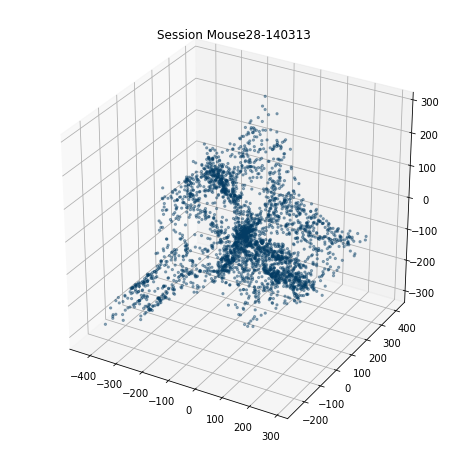

In [41]:
# plotting --- 22 + 22 #22 shuffled neurons added.
plot_manifold(counts_dimred) 

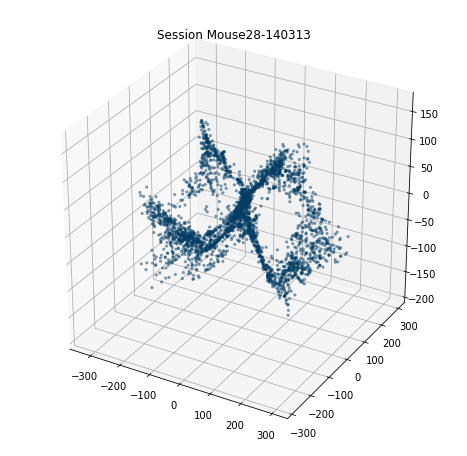

In [37]:
# plotting --- 22+5 #5 shuffled neurons added
plot_manifold(counts_dimred)

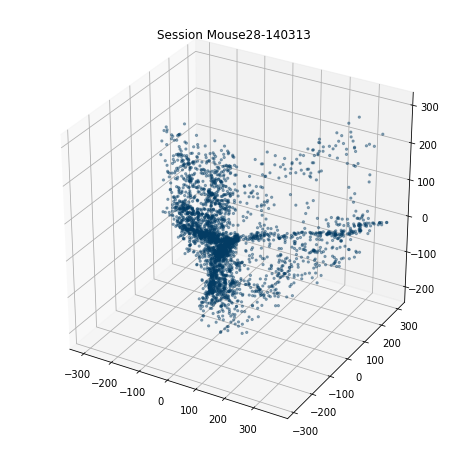

In [39]:
# plotting --- 22+10 #10 shuffled neurons added
plot_manifold(counts_dimred)

### Calculate Persistent Homology for Augmented Noisy Data

In [14]:
'''April 18th 2019
Use Ripser to get Betti bar codes from saved rates. If nCells > 10, dim reduce 
spike counts using Isomap. Threshold out low density points if thrsh is True.
'''

from __future__ import division
import sys, os
import time, datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from ripser import ripser as tda

sd=int((time.time()%1)*(2**31))
np.random.seed(sd)
curr_date=datetime.datetime.now().strftime('%Y_%m_%d')+'_'

gen_fn_dir = os.path.abspath('..') + '/shared_scripts'
sys.path.append(gen_fn_dir)

import general_file_fns as gff

gen_params = gff.load_pickle_file('../general_params/general_params.p')

from binned_spikes_class import spike_counts
from dim_red_fns import run_dim_red
from scipy.spatial.distance import pdist
from sklearn import neighbors

save_dir = gff.return_dir(gen_params['results_dir'] + '2019_03_22_tda/')

In [16]:
## run_persistent_homology
plot_barcode = True
cmd_line = False
# if thrsh is True then we threshold out low density points (nt-TDA in the 
# paper)
if cmd_line:
    session = sys.argv[1]
    state = sys.argv[2]
    thrsh = sys.argv[3]  # threshold out low density pts
else:
    session = 'Mouse28-140313'
    state = 'Wake'
    thrsh = False

area = 'ADn'
dt_kernel = 0.1
sigma = 0.1
d_idx = 10
rate_params = {'dt': dt_kernel, 'sigma': sigma}

# load the kernel spikes and smooth
print('Session: %s, state: %s' % (session, state))
session_rates = spike_counts(session, rate_params, count_type='rate',
                             anat_region='ADn')
rates_all = session_rates.get_spike_matrix(state)[0]
nCells_tot = rates_all.shape[1]
n_smooth_samples = np.floor(len(rates_all) / d_idx).astype(int)
sm_rates = np.zeros((n_smooth_samples, nCells_tot))
for i in range(n_smooth_samples):
    si = i * d_idx
    ei = (i + 1) * d_idx
    sm_rates[i] = np.mean(rates_all[si:ei], axis=0)

results = {'session': session, 'h0': [], 'h1': [], 'h2': []}


Session: Mouse28-140313, state: Wake


In [17]:
# *** Modify sm_rates to introduce irrelevant dimensions ***

print(sm_rates.shape)
import copy
sm_rates2 = copy.deepcopy(sm_rates)
np.random.shuffle(sm_rates2)
print(sm_rates2[0])
sm_rates12 = np.concatenate((sm_rates, sm_rates2), axis=1)
print(sm_rates12.shape)

(2286, 22)
[2.87929248e-185 1.22424515e-024 1.06779545e+001 1.81794971e-161
 1.25280880e+000 2.66665712e+000 9.34567668e-001 1.23439958e+001
 6.34832912e+000 6.05866620e+000 1.60100538e+000 4.54645657e-003
 0.00000000e+000 0.00000000e+000 4.99087639e+000 1.85271877e-001
 1.00104381e+000 0.00000000e+000 3.64466321e+001 2.73111292e+000
 5.20436617e-001 4.06806452e+000]
(2286, 44)


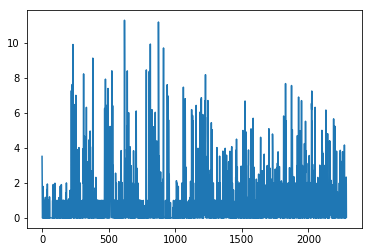

In [20]:
plt.plot(sm_rates[:,0])
plt.show()

In [43]:
# if greater than 10 cells, dim reduce to 10 dims using Isomap
fit_dim = 10
dr_method = 'iso'
n_neighbors = 5
dim_red_params = {'n_neighbors': n_neighbors, 'target_dim': fit_dim}
if nCells_tot > 10:
    rates = run_dim_red(sm_rates12, params=dim_red_params, method=dr_method)
else:
    rates = sm_rates

In [44]:
rates.shape

(2286, 10)

In [45]:
# threshold out outlier points with low neighborhood density
if thrsh:
    # a) find number of neighbors of each point within radius of 1st percentile of all
    # pairwise dist.
    dist = pdist(rates, 'euclidean')
    rad = np.percentile(dist, 1)
    neigh = neighbors.NearestNeighbors()
    neigh.fit(rates)
    num_nbrs = np.array(map(len, neigh.radius_neighbors(X=rates, radius=rad,
                        return_distance=False)))

    # b) threshold out points with low density
    thrsh_prcnt = 20
    threshold = np.percentile(num_nbrs, thrsh_prcnt)
    thrsh_rates = rates[num_nbrs > threshold]
    rates = thrsh_rates

In [46]:
# H0 & H1
H1_rates = rates
barcodes = tda(H1_rates, maxdim=1, coeff=2)['dgms']
results['h0'] = barcodes[0]
results['h1'] = barcodes[1]

In [50]:
results

{'h0': array([[  0.        ,   0.31350645],
        [  0.        ,   0.45062095],
        [  0.        ,   0.5424    ],
        ...,
        [  0.        ,  15.23573875],
        [  0.        ,  15.33227062],
        [  0.        , 100.        ]]),
 'h1': array([[21.56085587, 21.93566513],
        [20.10165977, 21.58076668],
        [20.02997398, 25.23979187],
        ...,
        [ 3.83724189,  4.26477003],
        [ 3.78246355,  4.35035563],
        [ 3.22493243,  3.22602725]]),
 'h2': array([[62.46401596, 62.50634766],
        [60.93920517, 61.00931931],
        [60.73716354, 61.16603851],
        [60.28177643, 61.2089386 ],
        [60.20380783, 61.54693604],
        [48.70484543, 49.59584427],
        [48.55335236, 49.32726669],
        [45.0339241 , 45.04904938],
        [44.22757339, 44.77875519],
        [43.82794189, 46.49116898],
        [43.15188217, 43.48015213],
        [42.40071869, 49.77876663],
        [42.28268814, 43.82938004],
        [41.63657761, 41.71639633],
    

In [49]:
# H2. Need to subsample points for computational tractability if 
# number of points is large (can go higher but very slow)
if len(rates) > 1500:
    idx = np.random.choice(np.arange(len(rates)), 1000, replace=False)
    H2_rates = rates[idx]
else:
    H2_rates = rates
barcodes = tda(H2_rates, maxdim=2, coeff=2)['dgms']
results['h2'] = barcodes[2]

In [42]:
# save
gff.save_pickle_file(results, save_dir + '%s_%s%s_ph_barcodes.p' % (session, state, ('_thresholded' * thrsh)))


1

In [40]:
len(rates)

2286

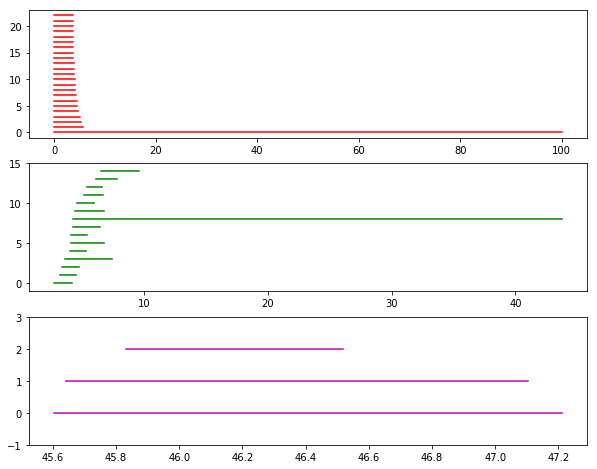

In [41]:
# If plotting from a saved file, uncomment this and replace with appropriate file.
# results = gff.load_pickle_file(gen_params['results_dir'] + '2019_03_22_tda/Mouse28-140313_Wake_ph_barcodes.p')

if plot_barcode:
    col_list = ['r', 'g', 'm', 'c']
    h0, h1, h2 = results['h0'], results['h1'], results['h2']
    # replace the infinity bar (-1) in H0 by a really large number
    h0[~np.isfinite(h0)] = 100
    # Plot the longest barcodes only
    plot_prcnt = [99, 98, 90] # order is h0, h1, h2
    to_plot = []
    for curr_h, cutoff in zip([h0, h1, h2], plot_prcnt):
         bar_lens = curr_h[:,1] - curr_h[:,0]
         plot_h = curr_h[bar_lens > np.percentile(bar_lens, cutoff)]
         to_plot.append(plot_h)

    fig = plt.figure(figsize=(10, 8))
    gs = gridspec.GridSpec(3, 4)
    for curr_betti, curr_bar in enumerate(to_plot):
        ax = fig.add_subplot(gs[curr_betti, :])
        for i, interval in enumerate(reversed(curr_bar)):
            ax.plot([interval[0], interval[1]], [i, i], color=col_list[curr_betti],
                lw=1.5)
        # ax.set_xlim([0, xlim])
        # ax.set_xticks([0, xlim])
        ax.set_ylim([-1, len(curr_bar)])
        # ax.set_yticks([])
    plt.show()

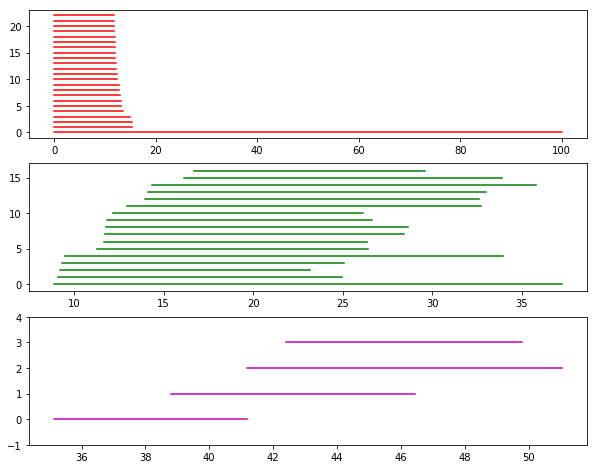

In [51]:
if plot_barcode:
    col_list = ['r', 'g', 'm', 'c']
    h0, h1, h2 = results['h0'], results['h1'], results['h2']
    # replace the infinity bar (-1) in H0 by a really large number
    h0[~np.isfinite(h0)] = 100
    # Plot the longest barcodes only
    plot_prcnt = [99, 98, 90] # order is h0, h1, h2
    to_plot = []
    for curr_h, cutoff in zip([h0, h1, h2], plot_prcnt):
         bar_lens = curr_h[:,1] - curr_h[:,0]
         plot_h = curr_h[bar_lens > np.percentile(bar_lens, cutoff)]
         to_plot.append(plot_h)

    fig = plt.figure(figsize=(10, 8))
    gs = gridspec.GridSpec(3, 4)
    for curr_betti, curr_bar in enumerate(to_plot):
        ax = fig.add_subplot(gs[curr_betti, :])
        for i, interval in enumerate(reversed(curr_bar)):
            ax.plot([interval[0], interval[1]], [i, i], color=col_list[curr_betti],
                lw=1.5)
        # ax.set_xlim([0, xlim])
        # ax.set_xticks([0, xlim])
        ax.set_ylim([-1, len(curr_bar)])
        # ax.set_yticks([])
    plt.show()

### Animation - to do

Traceback (most recent call last):
  File "/Users/yonar/opt/anaconda3/envs/spudenv2/lib/python2.7/site-packages/matplotlib/cbook/__init__.py", line 387, in process
    proxy(*args, **kwargs)
  File "/Users/yonar/opt/anaconda3/envs/spudenv2/lib/python2.7/site-packages/matplotlib/cbook/__init__.py", line 227, in __call__
    return mtd(*args, **kwargs)
  File "/Users/yonar/opt/anaconda3/envs/spudenv2/lib/python2.7/site-packages/matplotlib/animation.py", line 1026, in _start
    self._init_draw()
  File "/Users/yonar/opt/anaconda3/envs/spudenv2/lib/python2.7/site-packages/matplotlib/animation.py", line 1750, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
  File "/Users/yonar/opt/anaconda3/envs/spudenv2/lib/python2.7/site-packages/matplotlib/animation.py", line 1775, in _draw_frame
    raise RuntimeError('The animation function must return a '
RuntimeError: The animation function must return a sequence of Artist objects.


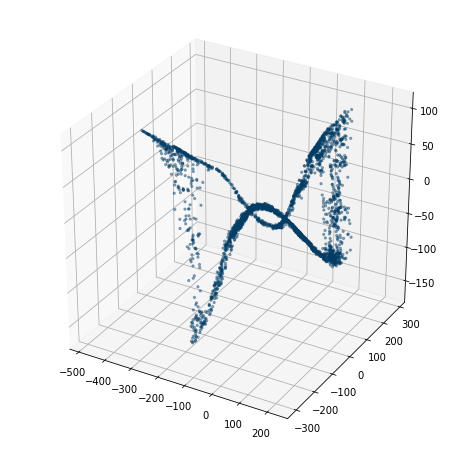

In [112]:
import matplotlib.animation as animation
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')


if target_dim == 3:
    ax.scatter(counts_dimred[:,0], counts_dimred[:,1], counts_dimred[:,2], 
        s=5, alpha=0.4, edgecolor='face', c=cols[state])
    
scat = ax.scatter(counts_dimred[0,0], counts_dimred[0,1], counts_dimred[0,2], 
        s=10, alpha=0.4, edgecolor='face', c='red')

def animate(i):   
    ax.scatter(counts_dimred[i,0], counts_dimred[i,1], counts_dimred[i,2], 
        s=10, alpha=0.4, edgecolor='face', c='red')
    
anim = animation.FuncAnimation(fig, animate, frames=2000, interval=1, blit=True)

plt.show()

In [ ]:
anim.save('coil.gif',writer='imagemagick')